In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [54]:
df = pd.read_csv(r"C:\Users\Bugra\OneDrive\Desktop\Datasets\Customer Churn DataSet.csv")

In [55]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [56]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nData Types:\n", df.dtypes)

Shape: (7043, 21)

Columns:
 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn           

In [57]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [58]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [59]:
df["TotalCharges"].isnull().sum()

np.int64(11)

In [60]:
df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"], inplace=True)

C:\Users\Bugra\AppData\Local\Temp\ipykernel_9328\661147379.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"], inplace=True)


In [61]:
y = df["Churn"].map({"Yes":1, "No":0})


In [62]:
df["Churn"].value_counts(normalize=True)*100


Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

## Expiloratory Data Analysis

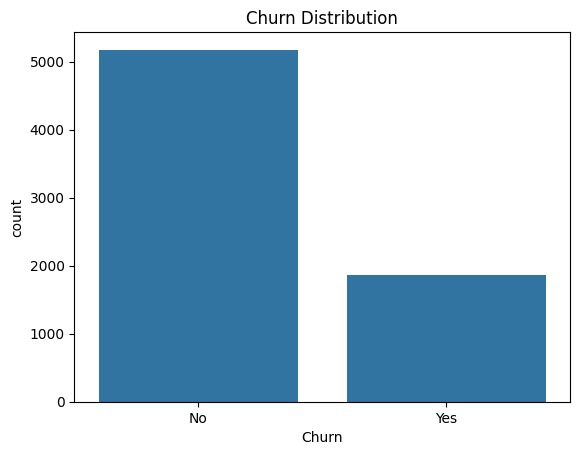

In [63]:
sns.countplot(data=df, x="Churn")
plt.title("Churn Distribution")
plt.show()



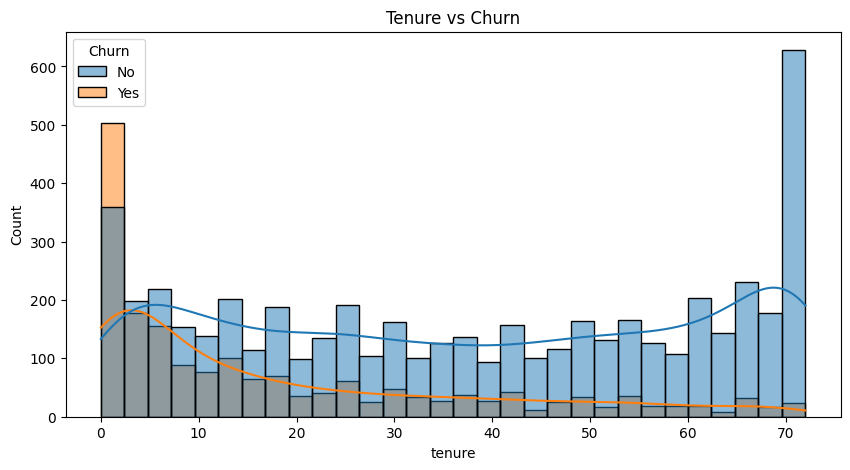

In [64]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x="tenure", hue="Churn", kde=True, bins=30)
plt.title("Tenure vs Churn")
plt.show()

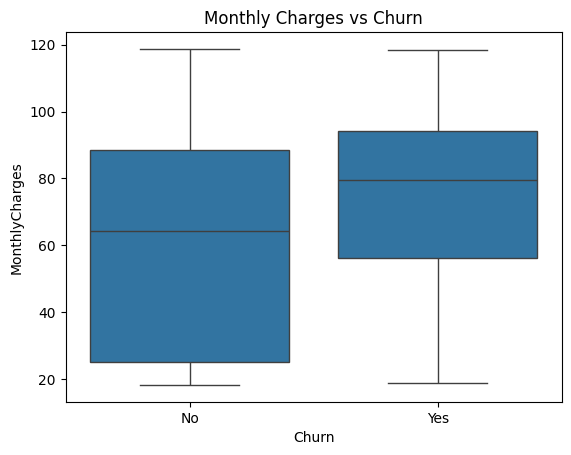

In [65]:
sns.boxplot(data=df, x="Churn", y="MonthlyCharges")
plt.title("Monthly Charges vs Churn")
plt.show()


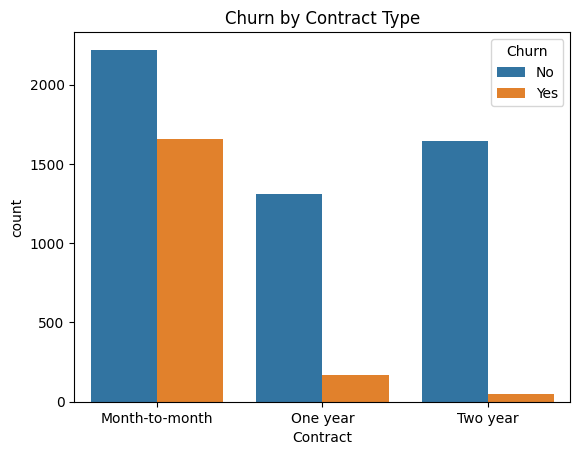

In [66]:
sns.countplot(data=df, x="Contract", hue="Churn")
plt.title("Churn by Contract Type")
plt.show()


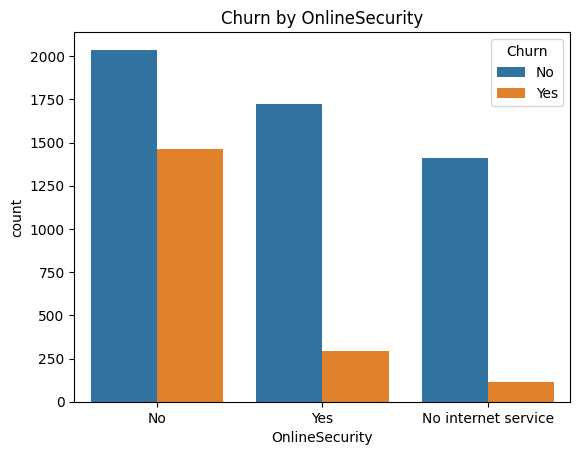

In [67]:
sns.countplot(data=df, x="OnlineSecurity", hue="Churn")
plt.title("Churn by OnlineSecurity")
plt.show()


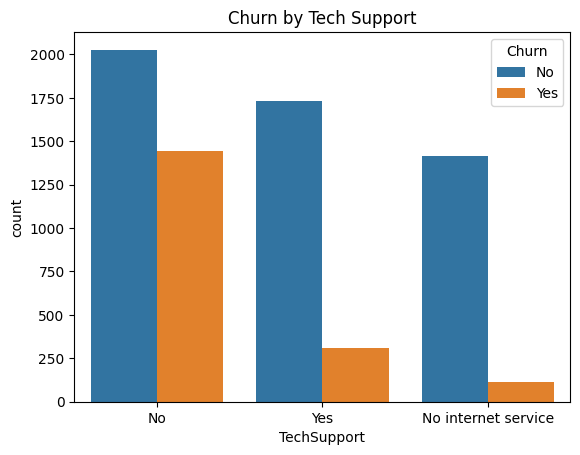

In [68]:
sns.countplot(data=df, x="TechSupport", hue="Churn")
plt.title("Churn by Tech Support")
plt.show()


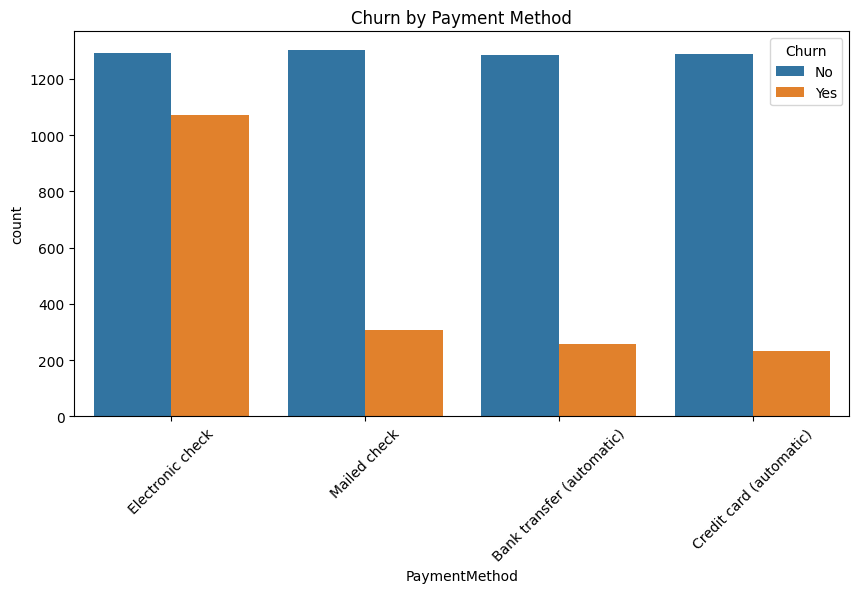

In [69]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="PaymentMethod", hue="Churn")
plt.xticks(rotation=45)
plt.title("Churn by Payment Method")
plt.show()


## Model prep

In [70]:
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes":1, "No":0})


In [71]:
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_cols = [col for col in X.columns if col not in numerical_cols]


In [72]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [74]:
cat_features = [X.columns.get_loc(col) for col in categorical_cols]

In [75]:
cat_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=5,
    loss_function="Logloss",
    eval_metric="AUC",
    random_state=42,
    verbose=100,
    class_weights=[1,3],   # remove this for better balance
    early_stopping_rounds=50
)

In [76]:
cat_model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    use_best_model=True
)

0:	test: 0.7944470	best: 0.7944470 (0)	total: 27.5ms	remaining: 41.3s
100:	test: 0.8402775	best: 0.8402775 (100)	total: 5s	remaining: 1m 9s
200:	test: 0.8427355	best: 0.8427355 (200)	total: 10.2s	remaining: 1m 6s
300:	test: 0.8426296	best: 0.8432264 (257)	total: 16s	remaining: 1m 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8432263815
bestIteration = 257

Shrink model to first 258 iterations.


In [77]:
# Predictions
y_pred = cat_model.predict(X_test)          # binary predictions (0/1)
y_prob = cat_model.predict_proba(X_test)[:, 1]   # probability of class 1

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[746 289]
 [ 76 298]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

AUC: 0.8432263814616756


## Shapley ad

In [36]:
!pip install shap
import shap 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\Bugra\anaconda3\python.exe -m pip install --upgrade pip


In [37]:
import shap

# Create explainer for CatBoost model
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)


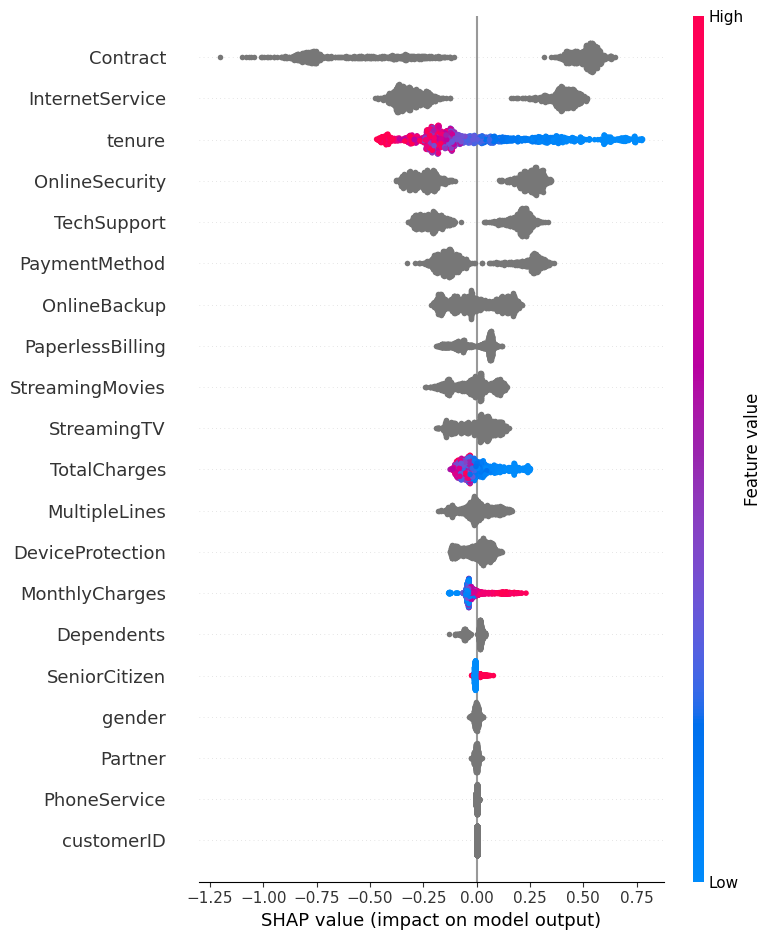

In [38]:
shap.summary_plot(shap_values, X_test)


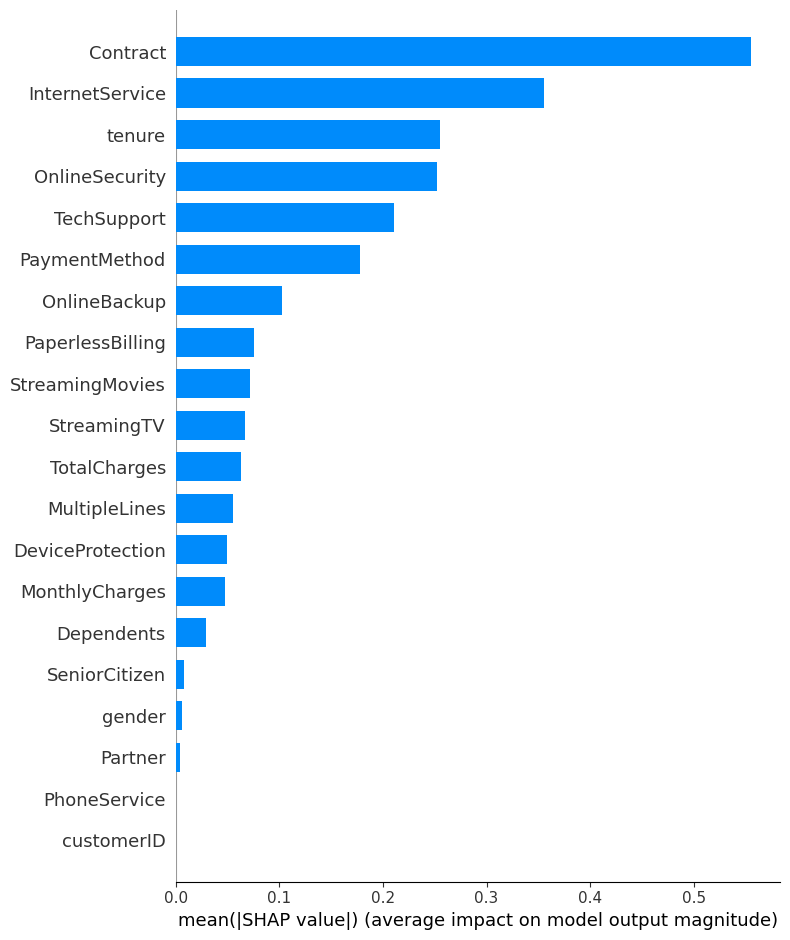

In [39]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [42]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)


## Churn Forecasting & Revenue Impact Modeling

In [86]:
df["churn_prob"] = cat_model.predict_proba(X)[:, 1]


In [87]:
expected_churn = df["churn_prob"].sum()
print("Expected churners:", expected_churn)


Expected churners: 2920.575311077007


In [80]:
df["rev_at_risk"] = df["MonthlyCharges"] * df["churn_prob"]
total_revenue_at_risk = df["rev_at_risk"].sum()

print("Estimated Monthly Revenue at Risk:", total_revenue_at_risk.round())


Estimated Monthly Revenue at Risk: 213429.0


In [83]:
df["Churn"] = df["Churn"].map({"Yes":1, "No":0})


In [85]:
ARPU = df["MonthlyCharges"].mean()
churn_rate = df["Churn"].mean()

CLV = ARPU / churn_rate
print("Customer Lifetime Value (CLV):", CLV)


Customer Lifetime Value (CLV): 244.04312466559657


In [91]:
reduced_churn_rate = churn_rate * 0.95
improved_CLV = ARPU / reduced_churn_rate

print("improved_CLV:" , improved_CLV)

improved_CLV: 256.8874996479964
